In [23]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects

oregon_washington_map = gpd.read_file("BLM_OR_County_Boundaries_Polygon_Hub.shp")
oregon_map = oregon_washington_map[oregon_washington_map['COBCODE'].str[:2] == "OR"].copy()

home_values = pd.read_csv("oregon_county_home_values.csv")

print(oregon_map)

    COUNTY_NAM COBCODE  ORIG_FID  \
0    JOSEPHINE   OR033        75   
1        CURRY   OR015        74   
2      JACKSON   OR029        73   
3         COOS   OR011        72   
4      KLAMATH   OR035        71   
5         LAKE   OR037        70   
6      DOUGLAS   OR019        69   
7       HARNEY   OR025        68   
8         LANE   OR039        67   
9    DESCHUTES   OR017        66   
10     MALHEUR   OR045        65   
11       CROOK   OR013        64   
12      BENTON   OR003        63   
13        LINN   OR043        62   
14   JEFFERSON   OR031        61   
15       GRANT   OR023        60   
16     LINCOLN   OR041        59   
17     WHEELER   OR069        58   
18        POLK   OR053        57   
19       BAKER   OR001        56   
20      MARION   OR047        55   
21     YAMHILL   OR071        54   
22   CLACKAMAS   OR005        53   
23       WASCO   OR065        52   
24  HOOD RIVER   OR027        51   
25   MULTNOMAH   OR051        50   
26     SHERMAN   OR055      

In [25]:
washington_counties = ["ADAMS", "ASOTIN", "CHELAN", "CLALLAM", "CLARK", "COWLITZ", "FERRY", "FRANKLIN", "GARFIELD", "GRAYS HARBOR", "ISLAND", "KING", "KITSAP", "KITTITAS", "KLICKITAT", "LEWIS", "MASON", "OKANOGAN", "PACIFIC", "PEND OREILLE", "PIERCE", "SAN JUAN", "SKAGIT", "SKAMANIA", "SNOHOMISH", "SPOKANE", "STEVENS", "THURSTON", "WAHKIAKUM", "WALLA WALLA", "WHATCOM", "WHITMAN", "YAKIMA"]

# rename the column to match
oregon_map = oregon_map.rename(columns={"COUNTY_NAM": "County"})
home_values = home_values.rename(columns={"Average Home Value Index": "HomeValueIndex"})

# filter out counties in Washington. They came with the shapefile
home_values = home_values[~home_values["County"].isin(washington_counties)]
oregon_map = oregon_map[~oregon_map["County"].isin(washington_counties)]

home_values.loc[13, "County"] = "HOOD RIVER"

# merge the shape file with the home value index file. Similar to a SQL join.
oregon_map = oregon_map.merge(home_values, on="County", how="left")

print(oregon_map)

        County COBCODE  ORIG_FID  \
0    JOSEPHINE   OR033        75   
1        CURRY   OR015        74   
2      JACKSON   OR029        73   
3         COOS   OR011        72   
4      KLAMATH   OR035        71   
5         LAKE   OR037        70   
6      DOUGLAS   OR019        69   
7       HARNEY   OR025        68   
8         LANE   OR039        67   
9    DESCHUTES   OR017        66   
10     MALHEUR   OR045        65   
11       CROOK   OR013        64   
12      BENTON   OR003        63   
13        LINN   OR043        62   
14   JEFFERSON   OR031        61   
15       GRANT   OR023        60   
16     LINCOLN   OR041        59   
17     WHEELER   OR069        58   
18        POLK   OR053        57   
19       BAKER   OR001        56   
20      MARION   OR047        55   
21     YAMHILL   OR071        54   
22   CLACKAMAS   OR005        53   
23       WASCO   OR065        52   
24  HOOD RIVER   OR027        51   
25   MULTNOMAH   OR051        50   
26     SHERMAN   OR055      

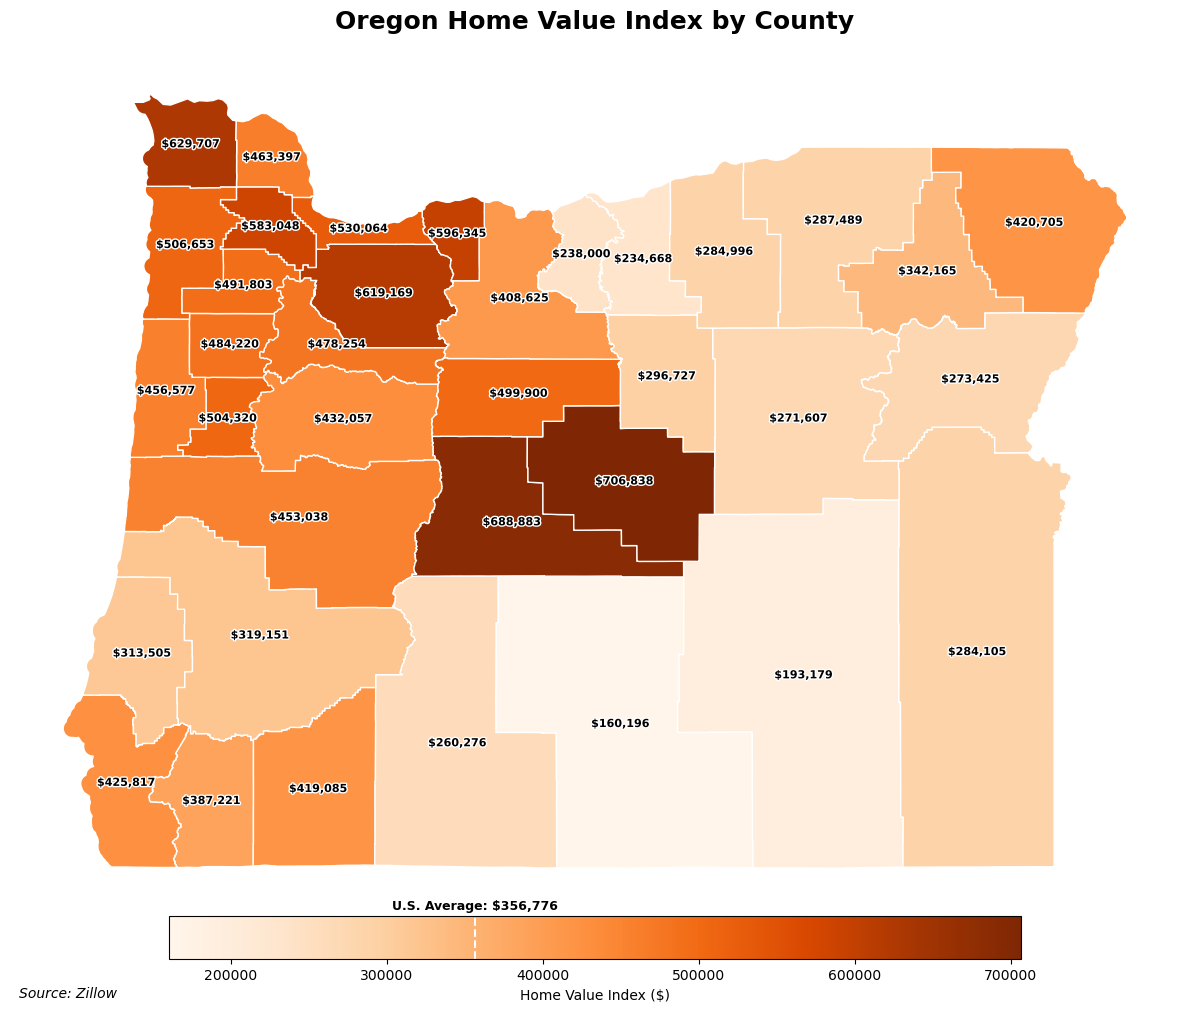

In [27]:
colors = ["#fff5eb", "#fee6ce", "#fdd0a2", "#fdae6b", "#fd8d3c", "#f16913", "#d94801", "#a63603", "#7f2704"]
custom_cmap = LinearSegmentedColormap.from_list("custom_oranges", colors)

# Calculate vmin and vmax before plotting
vmin = oregon_map['HomeValueIndex'].min()
vmax = oregon_map['HomeValueIndex'].max()

# Set up the figure
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the map with specified vmin and vmax
plot = oregon_map.plot(
    column="HomeValueIndex",
    cmap=custom_cmap,
    linewidth=1,
    edgecolor="white",
    legend=True,
    ax=ax,
    vmin=vmin,
    vmax=vmax,  # Explicitly set the data range
    legend_kwds={
        'label': "Home Value Index ($)",
        'orientation': "horizontal",
        'shrink': 0.8,
        'pad': 0.01,
        'fraction': 0.046
    }
)

# Get the colorbar axes
cbar = plot.get_figure().axes[1]  # Access the colorbar

# US Average value
avg_2025 = 356776

# Calculate normalized position for the average
marker_position = (avg_2025 - vmin) / (vmax - vmin)

if 0 <= marker_position <= 1:
    # Add a vertical line on the colorbar
    cbar.axvline(avg_2025, color='white', linewidth=1.5, linestyle='--')
    
    # Add text label above the colorbar
    label = 'U.S. Average: ${:,}'.format(avg_2025)
    cbar.text(
        marker_position, 1.1,  # Adjust y-coordinate for positioning
        label,
        ha='center', va='bottom',
        fontsize=9, fontweight='bold',
        transform=cbar.transAxes
    )

# Add county labels and other styling
for idx, row in oregon_map.iterrows():
    centroid = row.geometry.centroid
    try:
        value_text = f"${int(row['HomeValueIndex']):,}"
    except ValueError:
        value_text = "$0"
    ax.text(
        centroid.x, centroid.y, value_text,
        fontsize=8, ha='center', va='center',
        fontweight='bold', color='black',
        path_effects=[PathEffects.withStroke(linewidth=2, foreground='white')]
    )

ax.set_title("Oregon Home Value Index by County", fontsize=18, fontweight='bold', pad=20)
ax.set_axis_off()

plt.figtext(0.02, 0.02, "Source: Zillow", fontsize=10, fontstyle='italic')
plt.tight_layout()
plt.show()